# PROJECT-4. Решение комплексной бизнес-задачи
### Пархоменко Евгения Александровна
#### DARP 1014

### ЦЕЛЬ
Подготовить основу рекомендательной системы.

### ЗАДАЧИ
В рамках проверки гипотез необходимо решить четыре задачи:

1. Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
2. Обработать данные средствами Python.
3. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт продакт-менеджеру.
4. Проанализировать результаты A/B-теста, проведённого после внедрения фичи, и сделать вывод

### Ход проверки

Импортируем нужные библиотеки

In [37]:
import pandas as pd
import numpy as np
import psycopg2.extras
import seaborn as sns
from collections import Counter
import itertools
from itertools import combinations
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt


Запрашиваем данные из бызы  SQL

In [38]:
def get_data():
    query = '''
    SELECT *
FROM final.carts s
JOIN final.cart_items c ON  s.id = c.cart_id
WHERE state = 'successful' and resource_type = 'Course'
        '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data


df = pd.DataFrame(get_data()) 
df

,id,created_at,updated_at,purchased_at,state,user_id,promo_code_id,cart_id,resource_type,resource_id
0,522159,2017-01-19 07:50:41.313,2017-01-19 07:50:41.313,2017-01-19 07:52:08.590,successful,1010882,NaN,230789,Course,490
1,522063,2017-01-19 00:24:25.227,2017-01-19 00:24:25.227,2017-01-19 00:26:00.862,successful,1010802,NaN,230722,Course,514
2,522066,2017-01-19 01:39:19.788,2017-01-19 01:39:19.788,2017-01-21 06:37:48.453,successful,1011556,NaN,230725,Course,490
3,622915,2017-05-29 13:16:59.330,2017-05-29 13:16:59.330,2017-05-29 13:19:03.469,successful,1120298,NaN,283372,Course,514
4,575822,2017-04-03 16:57:20.690,2017-04-03 16:57:20.690,2017-04-03 17:02:07.947,successful,750528,NaN,258959,Course,552
...,...,...,...,...,...,...,...,...,...,...
70576,724958,2017-09-21 15:29:43.604,2017-09-21 15:29:43.604,2017-09-21 15:33:39.501,successful,1249905,NaN,336769,Course,566
70577,724967,2017-09-21 15:35:30.749,2017-09-21 15:35:30.749,2017-10-07 06:49:50.884,successful,718824,NaN,336775,Course,752
70578,1090677,2018-12-15 09:03:57.029,2018-12-15 09:03:57.029,2018-12-15 09:09:23.415,successful,1148335,NaN,745362,Course,490
70579,1020075,2018-10-09 05:29:38.079,2018-10-09 05:29:38.079,2018-10-09 05:34:56.634,successful,164310,NaN,769491,Course,1144


Проверяем, продажи за какие годы есть в ваших данных

In [39]:
print('Год начала продаж {}'.format(min(df['purchased_at'].dt.year)))
print('Год окончания продаж {}'.format(max(df['purchased_at'].dt.year)))

Год начала продаж 2017
Год окончания продаж 2018


Считаем, сколько клиентов покупали курсы

In [40]:
print('За рассматриваемый период курс купили {} клиентов'.format((df['user_id'].nunique())))

За рассматриваемый период курс купили 49006 клиентов


Считаем, сколько всего есть различных курсов

In [41]:
print('Всего различных курсов {}'.format((df['resource_id'].nunique())))

Всего различных курсов 126


Проверяем, каково среднее число купленных курсов на одного клиента

In [42]:
print('Cреднее число купленных курсов на одного клиента {}'.format(round(df['user_id'].count()/df['user_id'].nunique(),2)))

Cреднее число купленных курсов на одного клиента 1.44


Запрашиваем из бызы  SQL данные для итогового анализа

In [43]:
def get_data():
    query = '''
WITH T_1 as
(SELECT FC.user_id users,
count (FCI.resource_id) count_course
FROM final.carts FC
JOIN final.cart_items FCI on FCI.cart_id = FC.id
where FC.state = 'successful' and FCI.resource_type = 'Course'
group by FC.user_id
having count (distinct FCI.resource_id)>1),
T_2 as
(SELECT
FC.user_id,
FCI.resource_id
FROM final.carts FC
JOIN final.cart_items FCI on FCI.cart_id = FC.id
where FC.state = 'successful' and FCI.resource_type = 'Course'
order by FC.user_id
)
select
distinct T_1.users,
T_2.resource_id
FROM T_1
left join T_2 on T_1.users = T_2.user_id
order by T_1.users

        '''
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data


df_1 = pd.DataFrame(get_data()) 
df_1


,users,resource_id
0,51,516
1,51,1099
2,6117,356
3,6117,1125
4,6117,357
...,...,...
34069,2188926,515
34070,2188926,743
34071,2190141,756
34072,2190141,794


Считаем, сколько клиентов купили больше одного курса

In [44]:
print('Больше одного курса купили {} клиентов'.format((df_1['users'].nunique())))

Больше одного курса купили 12656 клиентов


Группируем все купленные курсы по клиентам

In [45]:
course_lists = df_1.groupby('users')['resource_id'].apply(lambda x:list(np.unique(x))).reset_index()
course_lists

,users,resource_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"
...,...,...
12651,2179430,"[566, 750]"
12652,2186581,"[794, 864, 1129]"
12653,2187601,"[356, 553, 571, 765, 912]"
12654,2188926,"[515, 743]"


Считаем, сколько различных пар курсов встречаются вместе в покупках клиентов

In [60]:
courses = list()
for course in course_lists['resource_id']:
    for value in itertools.combinations(course, 2):
        courses.append(value)
count_of_courses=Counter(courses)
sorted_count_corses=sorted(count_of_courses.items(),key=lambda item:item[1],reverse=True)
display(len(sorted_count_corses))
x = Counter([pair for pair in courses])
print(x)

3989

Counter({(551, 566): 797, (515, 551): 417, (489, 551): 311, (523, 551): 304, (566, 794): 290, (489, 515): 286, (490, 566): 253, (490, 551): 247, (570, 752): 247, (569, 572): 216, (515, 523): 213, (553, 745): 212, (489, 523): 206, (569, 840): 204, (514, 551): 200, (516, 745): 199, (515, 566): 195, (489, 566): 188, (504, 572): 184, (572, 840): 178, (551, 552): 177, (507, 570): 172, (490, 809): 163, (489, 490): 152, (507, 752): 150, (523, 552): 144, (490, 515): 143, (551, 570): 142, (504, 569): 139, (514, 515): 139, (551, 745): 138, (514, 566): 138, (502, 551): 135, (504, 840): 135, (571, 1125): 122, (502, 566): 120, (523, 566): 120, (570, 809): 119, (752, 809): 115, (490, 523): 114, (357, 571): 112, (523, 564): 110, (551, 749): 109, (516, 553): 107, (551, 777): 107, (551, 679): 104, (356, 571): 103, (551, 564): 103, (515, 749): 103, (568, 745): 102, (356, 357): 100, (363, 511): 99, (551, 571): 98, (551, 809): 96, (502, 514): 95, (551, 794): 95, (490, 514): 94, (566, 764): 92, (490, 564):

In [47]:
display(sorted_count_corses)

[((551, 566), 797),
 ((515, 551), 417),
 ((489, 551), 311),
 ((523, 551), 304),
 ((566, 794), 290),
 ((489, 515), 286),
 ((490, 566), 253),
 ((490, 551), 247),
 ((570, 752), 247),
 ((569, 572), 216),
 ((515, 523), 213),
 ((553, 745), 212),
 ((489, 523), 206),
 ((569, 840), 204),
 ((514, 551), 200),
 ((516, 745), 199),
 ((515, 566), 195),
 ((489, 566), 188),
 ((504, 572), 184),
 ((572, 840), 178),
 ((551, 552), 177),
 ((507, 570), 172),
 ((490, 809), 163),
 ((489, 490), 152),
 ((507, 752), 150),
 ((523, 552), 144),
 ((490, 515), 143),
 ((551, 570), 142),
 ((504, 569), 139),
 ((514, 515), 139),
 ((551, 745), 138),
 ((514, 566), 138),
 ((502, 551), 135),
 ((504, 840), 135),
 ((571, 1125), 122),
 ((502, 566), 120),
 ((523, 566), 120),
 ((570, 809), 119),
 ((752, 809), 115),
 ((490, 523), 114),
 ((357, 571), 112),
 ((523, 564), 110),
 ((551, 749), 109),
 ((516, 553), 107),
 ((551, 777), 107),
 ((551, 679), 104),
 ((356, 571), 103),
 ((551, 564), 103),
 ((515, 749), 103),
 ((568, 745), 102),

Смотрим частотность встречающихся пар курсов

In [48]:
df_2 = pd.DataFrame(sorted_count_corses)
df_2.columns = ['pairs', 'frequency']
df_2

,pairs,frequency
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290
...,...,...
3984,"(741, 791)",1
3985,"(361, 1128)",1
3986,"(743, 1156)",1
3987,"(864, 1129)",1


<Axes: title={'center': 'Распределение частотности'}, ylabel='Frequency'>

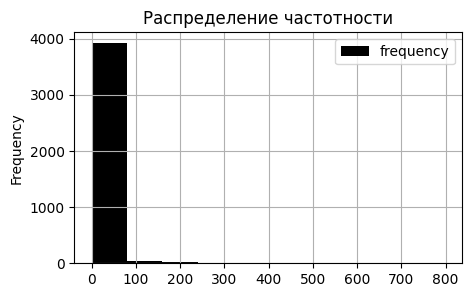

In [49]:
df_2.plot(
    kind='hist',
    figsize=(5, 3),
    title='Распределение частотности',
    grid = True,
    color = 'black',
    bins=10
)

In [50]:
np.percentile(df_2['frequency'], 78)

10.0

<Axes: title={'center': 'Распределение частотности'}, ylabel='Frequency'>

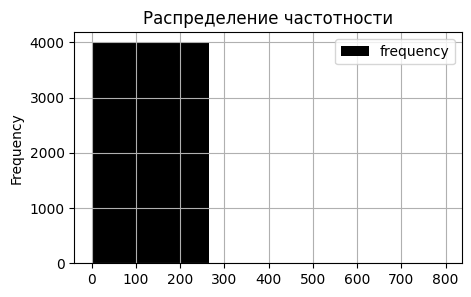

In [51]:
df_2.plot(
    kind='hist',
    figsize=(5, 3),
    title='Распределение частотности',
    grid = True,
    color = 'black',
    bins=3
)

In [52]:
np.percentile(df_2['frequency'], 50)

3.0

ВЫВОД: 78 % пар выпадают за границу 10 совпадений. Всего у нас курсов 126, соотвественно, если рекомендовать пары, которые имеют более 10 совпадений, то мы можем добавить в рекомендации только 28 кусов.

Здесь есть два варианта пути:
- оставить к рекомендации 28 курсов;
- увеличить нижнюю границу до 50 персентиля (включаем все курсы с 3 совпадениями и более)

In [90]:
df_2['rec_1']=df_2['pairs'].str.get(0)
df_2['rec_2']=df_2['pairs'].str.get(1)
df_2

,pairs,frequency,rec_1,rec_2
0,"(551, 566)",797,551,566
1,"(515, 551)",417,515,551
2,"(489, 551)",311,489,551
3,"(523, 551)",304,523,551
4,"(566, 794)",290,566,794
...,...,...,...,...
3984,"(741, 791)",1,741,791
3985,"(361, 1128)",1,361,1128
3986,"(743, 1156)",1,743,1156
3987,"(864, 1129)",1,864,1129


In [103]:
list_unique_course = (df_1['resource_id'].unique())
list_unique_course

array([ 516, 1099,  356, 1125,  357, 1147,  553, 1138,  361, 1140,  745,
        551,  568,  566,  514,  517,  363,  511,  562,  563,  509, 1144,
        672,  552,  571,  513, 1141,  862,  744,  679,  750,  800,  569,
        840,  765, 1187, 1103, 1100,  564,  865,  502,  764, 1139, 1186,
        366,  367,  519,  809,  515,  912,  489,  523,  864, 1146, 1101,
        776,  671,  753,  829,  490, 1102,  803,  659,  909,  794,  518,
        907,  777,  908,  360,  813,  835, 1115,  752,  741, 1116, 1161,
        814,  863,  743,  572,  504, 1124, 1128,  810,  742, 1104,  503,
        664,  507,  570, 1185, 1198,  365,  359,  791, 1156,  362, 1184,
        911,  358, 1160,  757, 1181,  508,  755, 1145, 1188,  756,  866,
        749,  368,  364,  834, 1152,  670, 1199,  836, 1201, 1129, 1182,
        902,  837, 1200,  833,  830], dtype=int64)

In [107]:
unique_course = pd.DataFrame(list_unique_course)
unique_course.columns = ['unique_course']
unique_course

,unique_course
0,516
1,1099
2,356
3,1125
4,357
...,...
121,902
122,837
123,1200
124,833


In [94]:
popular_course = df['resource_id'].value_counts().index.tolist()


In [91]:
df_2

,pairs,frequency,rec_1,rec_2
0,"(551, 566)",797,551,566
1,"(515, 551)",417,515,551
2,"(489, 551)",311,489,551
3,"(523, 551)",304,523,551
4,"(566, 794)",290,566,794
...,...,...,...,...
3984,"(741, 791)",1,741,791
3985,"(361, 1128)",1,361,1128
3986,"(743, 1156)",1,743,1156
3987,"(864, 1129)",1,864,1129


In [108]:
df_recomendations = pd.DataFrame(columns = ['course','recomendation_1','recomendation_2'])
df_recomendations['recomendation_1'] = df_2['rec_1']
df_recomendations['recomendation_2'] = df_2['rec_2']
df_recomendations['course'] = unique_course['unique_course']
df_recomendations

,course,recomendation_1,recomendation_2
0,516.0,551,566
1,1099.0,515,551
2,356.0,489,551
3,1125.0,523,551
4,357.0,566,794
...,...,...,...
3984,NaN,741,791
3985,NaN,361,1128
3986,NaN,743,1156
3987,NaN,864,1129
